# Varia

In this chapter we will look into couple different architectures, saliency and other tricks, which did not found their own chapters. Each section will have open-ended task for you to experiment with.

In [1]:
import pickle
import gzip
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, datasets
from torch import nn, optim
from IPython import display
from time import sleep
from PIL import Image
from tqdm import tqdm

## Transfer Learning

Since lower level features in networks for image tasks turn out to be quite basic we can transfer this knowledge to new datasets by training only later layers.

<img width=50% src="https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png">

For example let's take MobileNet pre-trained on imagenet and chop it's end. 

In [2]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Load Fashion MNIST with transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to be compatible with MobileNet
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Step 2: Modify model for 1-channel input, update the final layer, and send to device
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Freeze all layers' weights except for conv1 and the final classification layer
for name, param in model.named_parameters():
    if name not in ["conv1.weight", "fc.weight", "fc.bias"]:
        param.requires_grad = False

# Add the last trainable layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Send model to device
model = model.to(device)

# Step 3: Define optimizer, loss function, and move them to the device
optimizer = optim.SGD([
        {'params': model.conv1.parameters()},
        {'params': model.fc.parameters()}
    ], lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(10):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the device
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Using device: mps


100%|█████████████████████████████████████████| 938/938 [00:30<00:00, 30.88it/s]


Epoch 1, Loss: 0.9756850496029803


100%|█████████████████████████████████████████| 938/938 [00:30<00:00, 31.15it/s]


Epoch 2, Loss: 0.7356271022227782


100%|█████████████████████████████████████████| 938/938 [00:29<00:00, 31.27it/s]


Epoch 3, Loss: 0.6794217945034824


100%|█████████████████████████████████████████| 938/938 [00:29<00:00, 31.58it/s]


Epoch 4, Loss: 0.6545539951718438


100%|█████████████████████████████████████████| 938/938 [00:29<00:00, 31.55it/s]


Epoch 5, Loss: 0.6321801520359795


100%|█████████████████████████████████████████| 938/938 [00:29<00:00, 31.47it/s]


Epoch 6, Loss: 0.6211532306061116


100%|█████████████████████████████████████████| 938/938 [00:29<00:00, 31.29it/s]


Epoch 7, Loss: 0.606150176320503


100%|█████████████████████████████████████████| 938/938 [00:29<00:00, 31.32it/s]


Epoch 8, Loss: 0.6007817822859994


100%|█████████████████████████████████████████| 938/938 [00:29<00:00, 31.41it/s]


Epoch 9, Loss: 0.5912473409859611


100%|█████████████████████████████████████████| 938/938 [00:29<00:00, 31.66it/s]

Epoch 10, Loss: 0.5835546002522715


Accuracy of the network on the 10000 test images: 79.39 %


In [3]:
# Initialize counters
total_params = 0
trainable_params = 0
non_trainable_params = 0

# Iterate through the model's parameters
for param in model.parameters():
    # Sum up the total number of parameters
    total_params += param.numel()
    # Check if the parameter is trainable
    if param.requires_grad:
        # Sum up the number of trainable parameters
        trainable_params += param.numel()
    else:
        # Sum up the number of non-trainable parameters
        non_trainable_params += param.numel()

# Print the counts
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 11181642
Trainable parameters: 14538
Non-trainable parameters: 11167104


Note the number of trainable parameters. For sure it's possible to update original weights too, but fixing them is a usually a good starting point. Some forums suggest unfreezing them gradually after top layer training slows down.

**TASK:** can you improve the example above and get a better accuracy on Fashion MNIST dataset?

## Saliency

There is the myth that NN's are hard to interpret and there is no clear way to interpret feature importance. It turns out that this is quite easy and we can use backpropagation itself for that. Think about the maning of the abosulte value of $\frac{d_{out}}{d_{input}}$. This value will be high for features which are highly contributing for the output! 

Gradients can be calculated in PyTorch using:

```python
x = torch.tensor(3.0, requires_grad=True)
y = x ** 2
# Compute the gradients
y.backward()
# Print the gradient at x = 3
print(x.grad)
```

this will calculate $\frac{dy}{dx}$ at point $3$, thus yielding $6$.

In [4]:
def saliency(model, single_input):
    single_input.requires_grad = True
    
    # Forward pass
    predictions = model(single_input)
    
    # Assuming a regression task, use the output directly
    model.zero_grad()
    predictions.backward(torch.ones_like(predictions))
    
    # Gradients of the model's output with respect to the input
    gradients = single_input.grad.abs().data.numpy()
    
    return gradients

To test this out let's make a simple dataset where *y* is averate of first two columns and third column is not used.

In [5]:
X = np.random.normal(size=(1000, 3)).astype(np.float32)
y = ((X[:, 0] + X[:, 1]) / 2).reshape(-1, 1).astype(np.float32)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y)

Now let's fit simple regression NN and look at salience.

In [6]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.dense1 = nn.Linear(3, 5)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dense2(x)
        return x

# Model, loss and optimizer
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

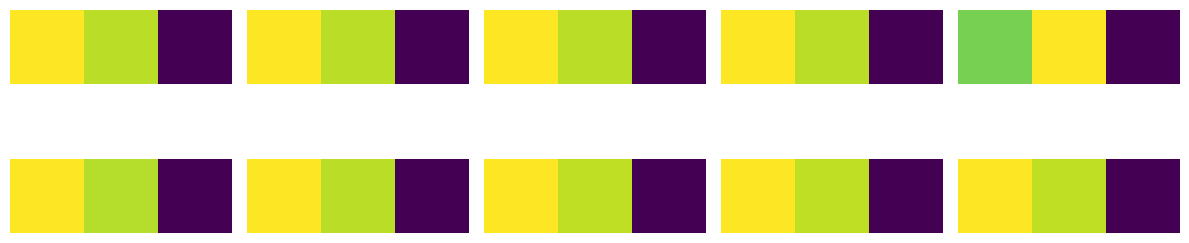

In [7]:
plt.figure(figsize=(12, 4))
for i in range(10):
    saliency_map = saliency(model, X_tensor[i:i+1])
    plt.subplot(2, 5, i + 1)
    plt.imshow(saliency_map.reshape(-1, 3))
    plt.axis('off')

plt.tight_layout()
plt.show()

Nice, nearly all value comes from first two features, exactly as expected. If you will increase epoch count and overfit train data weights should even up (try that).

**TASK:** take your own flatland model and visualize salience.

## Architectures

There are a lot of possible architectures, we have only touched the surface. Take a glympse at the variations of Neural Networks [here](https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464).

<img src="https://miro.medium.com/max/2000/1*cuTSPlTq0a_327iTPJyD-Q.png" style="width: 80%"/>

### Autoencoders

Autoencoders try to squeeze data by having a bottleneck layer (see viz above). Using Autoencoders we can easily replicate SVD and PCA. And as you know this can be used in data compression, recommenders, outlier detectors etc. Not only that NN's allow to make much richer autoencoders, thus improving quality.

Let's go back to a part of SVD lecture and try to compress image using NN.

In [8]:
def plot(X):
    """Just a little helper function to get a nice image plot"""
    m = 255 if X.max() > 200 else 1
    plt.imshow(X, cmap='gray', vmin=0, vmax=m)
    plt.axis('off')

In [9]:
!curl https://raw.githubusercontent.com/trokas/ai_primer/master/img/castle.jpg --output castle.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9217  100  9217    0     0  37547      0 --:--:-- --:--:-- --:--:--     0-:-- --:--:-- --:--:-- 37467


Image shape (312, 198)


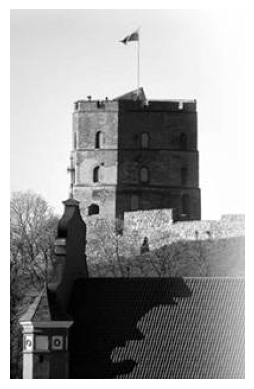

In [10]:
img = Image.open('castle.jpg')
img.load()
X = np.asarray(img, dtype="int32")
print(f'Image shape {X.shape}')
plot(X)

As you might remember we did compression using SVD.

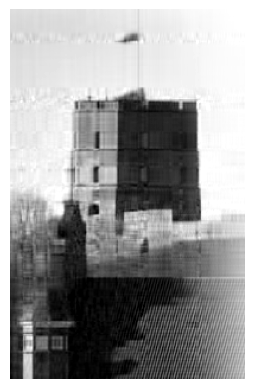

In [11]:
N = 20    # Compression

U, S, V = np.linalg.svd(X)
plot((U[:,:N] * S[:N]).dot(V[:N]))

Before training NN, let's scale down and center our inputs. Scaling this time is important!

In [12]:
X = X.astype('float32') / 255.
means = X.mean(axis=0)
X = X - means

X_tensor = torch.tensor(X, dtype=torch.float32)

In [13]:
class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 20, bias=False)
        self.dense2 = nn.Linear(20, input_size, bias=False)
        
    def forward(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x
    
model = MyModel(X_tensor.shape[1])

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch in range(1000):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, X_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

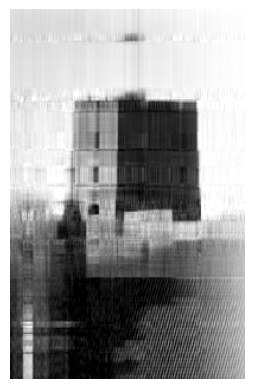

In [14]:
# Plotting the reconstructed data
with torch.no_grad():  # We don't need gradients for plotting
    reconstructed = model(X_tensor).numpy() + means
    plot(reconstructed)

Result looks really similar to what we get from SVD. What have we learned here? 

We have just performed a matrix decomposition, since $X \approx X W^T V^T$. Let's cite from Neural Networks and Deep Learning, a textbook by Chrau C. Aggarwal:

> Note that the autoencoder creates the reconstructed representation $D W^T V^T$ of the original data matrix. Therefore, it tries to optimize the problem of minimizing $||DW^T V^T − D||^2$. The optimal solution to this problem is obtained when the matrix $W$ contains the pseudo-inverse of $V$.

Let's check this statement

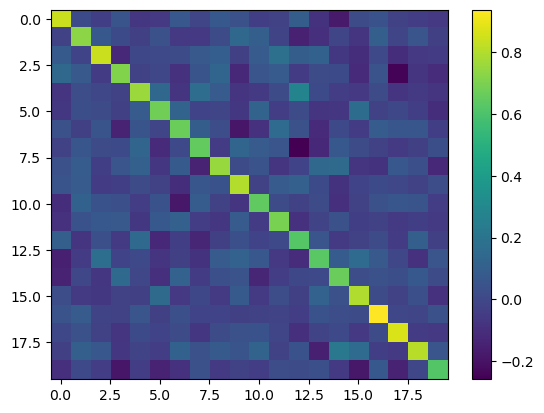

In [15]:
# Accessing and plotting the dot product of weights
with torch.no_grad():
    W = model.dense1.weight.detach().numpy()
    A = model.dense2.weight.detach().numpy()
    plt.imshow(W.dot(A), aspect='auto')
    plt.colorbar()
    plt.show()

**TASK:** let's go back to SVD lecture and Olivetti faces (`sklearn.datasets.fetch_olivetti_faces`) anomaly detection problem - flip one or couple of images upside down so that they would look like anomalies, then encode and decode. Use slightly deeper NN for anomaly detection and show that it produces more powerfull detector than PCA.

### Word2Vec & CNN's

Word2Vec is built using autoencoders and allows to convert words to vectors which have some semantic meaning. Some applications of these vectors might be stunning, for example:

<img width=50% src="http://jalammar.github.io/images/word2vec/king-analogy-viz.png"/>

To use pre-trained model we will use Spacy library (install it using `pipenv install spacy`). Then download the model by running `python -m spacy download en_core_web_md`. Remeber that you can run shell commands in notebook by adding `!`.

From here you can get embeddings as follows.

In [16]:
#!python -m spacy download lt_core_news_md

In [17]:
import spacy

nlp = spacy.load('lt_core_news_md')
sentance = nlp("katė šuo")
embeddings = np.array([word.vector for word in sentance])
embeddings.shape

(2, 300)

It is interesting to explore word reconstructions by mapping it to vector, performing some operations and going back using a distance measure. You can find more neat examples and high level explanation of Word2Vec in a book [The Alignment Problem](https://www.goodreads.com/en/book/show/50489349-the-alignment-problem).

To have more fun examples you will have to use much bigger model. Install gensim using `!pip install gensim` and download [model file](https://code.google.com/archive/p/word2vec/#:~:text=GoogleNews%2Dvectors%2Dnegative300.bin.gz) which is 1.5G. Then play with it, for example

```python
import gensim
import gensim.downloader as api
model = api.load('word2vec-google-news-300')
model.most_similar_cosmul(positive=['king', 'woman'], negative=['man'])

>> [('queen', 0.9314123392105103),
>>  ('monarch', 0.858533501625061),
>>  ('princess', 0.8476566672325134), ...]

model.most_similar_cosmul(positive=['fish', 'music'])

>> [('bass', 0.5192274451255798),
>>  ('catfish', 0.5176859498023987),
>>  ('trout', 0.5006918907165527), ...]
```

As you might expect these vectors can be used while creating the model, for example we can make sentiment analysis model for reviews (trying to figure out if it is positive or negative) simply by feeding embedding to CNN.

<img width=60% src="https://datasciencetoday.net/images/CNN.png"/>

**TASK:** using data from [imdb reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) train simple CNN based sentiment classifier.

## Mimics

If you ever need to compress the model due to some hardware or inference time constraints there is a simple trick that can help. Called mimic or teacher-student network, the idea is to train simpler model to do the same thing that a bigger model does. It is achieved by:
1. Creating a big and good model (can be an ensemble of models) that outputs softmax probabilities.
2. Pass a bunch of unlabeled examples via this teacher network and store his outputs.
3. Use these outputs to train a smaller model. You don't even need original training data now.
Try to think of the reasons why this trick works well. For more details see [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531) and [Do Deep Nets Really Need to be Deep?](https://arxiv.org/abs/1312.6184).

**TASK:** even though we do not have unlabeled data in flatland's project, try out mimic approach on your best model to see if you can reduce size without loosing too much accuracy.

## Mixup

Another cool idea is to mix two images and their classes into one and use such embedded image as a training example. For example, if we take MNIST, then we can randomly pick two different numbers and fuse images $A$ and $B$ by constructing their linear combination $\lambda A + (1 - \lambda) B$. Doing the same for their classes gives us the expected outcome that is used for training $\lambda y_A + (1 - \lambda) y_B$. For more details see [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412).

Both Mimics (Knowladge Distilation) and Mixup are frequently used tricks (see [bag of tricks paper](https://arxiv.org/abs/1812.01187)).

**TASK:** test this out on MNIST or flatland project.

## Permutation Feature Importance

Sometime you want to know which feature is most valuable. As we saw with Random Forests it can be done knowing how the algorithm is constructed. On the other hand it is useful to have a model agnostic approach that can be used without thinking about the model itself. Principle of permutation importance is quite simple - just shuffle a single column and measure the loss in accuracy. While estimating importance it's a good practice to use test set. Idea is explored in paper "All models are wrong, but many are useful: ..." by Fisher, Rudin, and Dominici (2018). Even though it's quite trivial to implement on your own you might find [scikit-learn implementation](https://scikit-learn.org/stable/modules/permutation_importance.html) useful.